In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Part B: Regression Problem**

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
import time
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string, divisor):
    print("---Feature: %s ---" % name)
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)
    print("this is vocab size ", lookup.vocabulary_size())
    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    
    num_categories = len(df[name].unique())
    print("this is num of categories ",num_categories)
    input_dim = lookup.vocabulary_size()
    output_dim = int(np.floor(num_categories//divisor))
    print("this is input dim ", input_dim, " and output dim ", output_dim)

    encoded_cat_embedding = keras.layers.Embedding(input_dim, output_dim, name=name+'-Embedding')(encoded_feature)
    encoded_cat_vec = keras.layers.Flatten(name='Flatten'+name)(encoded_cat_embedding)
    return encoded_cat_vec


In [ ]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## **Q3**

**Model degradation is a common issue faced when deploying neural network models in the real
world. In typical coursework settings, you learn the ropes by experimenting on toy datasets, which
only offers a static snapshot of the situation. Real life problems, such as the analysis of factors
influencing HDB prices, have new data points coming in daily that might exhibit a different pattern
from older data points due to factors such as changes in government policy or market sentiments.
In such situations, models trained on older data points that differ greatly from the new data could
perform poorly. In the last part of this assignment, we will investigate whether this has happened.**

**There are 2 datasets to work with: ‘HDB_price_prediction.csv’ and ‘HDB_price_prediction_old.csv’.
The latter is a subset of the former: both start from the same date but the latter ends on August
2021 while the former has data until August 2022. Both have the same set of training data (2020
and before) but the test data for the latter (i.e. ‘old test set’) is up till August 2021, while the test
set from the former has complete data from 2021, along with data till August 2022 (‘new test set’)**

#### **a) Apply your model from Q2d on the ‘old test set’. On the ‘new test set’, split it into 2021 and 2022. For all 3 test sets, report the test R2 value you obtained.**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CZ4042/hdb_price_prediction.csv')
df = df.drop(["full_address", "nearest_stn"], axis=1)
df.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
old_df = pd.read_csv('/content/drive/MyDrive/CZ4042/Part B/hdb_price_prediction_old.csv')
old_df = old_df.drop(["full_address", "nearest_stn"], axis=1)
old_df.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
train_dataframe = df[df.year < 2021].reset_index(drop=True)

old_test_dataframe = old_df[old_df.year > 2020].reset_index(drop=True)
new_test_dataframe_2021 = df[(2020 < df.year) & (df.year < 2022)].reset_index(drop=True)
new_test_dataframe_2022 = df[df.year > 2021].reset_index(drop=True)

In [ ]:
batch_size = 256

In [ ]:
train_ds = dataframe_to_dataset(train_dataframe)
old_test_ds = dataframe_to_dataset(old_test_dataframe)
new_test_ds_2021 = dataframe_to_dataset(new_test_dataframe_2021)
new_test_ds_2022 = dataframe_to_dataset(new_test_dataframe_2022)

train_ds = train_ds.batch(batch_size)
old_test_ds = old_test_ds.batch(batch_size)
new_test_ds_2021 = new_test_ds_2021.batch(batch_size)
new_test_ds_2022 = new_test_ds_2022.batch(batch_size)

In [ ]:
# test dictionary to map name and test dataset
test_data = {
    "old_test": old_test_ds,
    "new_test_2021": new_test_ds_2021,
    "new_test_2022": new_test_ds_2022
}

In [ ]:
def encodeInputFeature(categoricalDict, numericList, divisor):
  all_inputs = []
  all_features = []
  for cat, typ in categoricalDict.items():
    print(cat)
    encoded_cat = keras.Input(shape=(1,), name=cat, dtype=typ)
    all_inputs.append(encoded_cat)
    if typ == "int64":
      all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, False, divisor))
    else:
      all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, True, divisor))
  for num in numericList:
    print(num)
    encoded_num = keras.Input(shape=(1,), name=num)
    all_inputs.append(encoded_num)
    all_features.append(encode_numerical_feature(encoded_num, num, train_ds))
  return all_inputs, layers.concatenate(all_features)

In [ ]:
# the best set of hyperparameters from Q2
hp_best_config = {'divisor': 2, 'units': 12, 'learning_rate': 0.19475490890173586}
hp_best_config

{'divisor': 2, 'units': 12, 'learning_rate': 0.19475490890173586}

In [ ]:
categoricalDict = {
    "month": "int64",
    "flat_model_type": "string",
    "storey_range": "string"
}
numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
all_inputs, all_features = encodeInputFeature(categoricalDict, numericList, divisor=hp_best_config['divisor'])

month
---Feature: month ---
this is vocab size  13
this is num of categories  12
this is input dim  13  and output dim  6
flat_model_type
---Feature: flat_model_type ---
this is vocab size  44
this is num of categories  44
this is input dim  44  and output dim  22
storey_range
---Feature: storey_range ---
this is vocab size  18
this is num of categories  17
this is input dim  18  and output dim  8
dist_to_nearest_stn
dist_to_dhoby
degree_centrality
eigenvector_centrality
remaining_lease_years
floor_area_sqm


In [ ]:
# the folder name in submission is 'best_model'
checkpoint_filepath = ('/content/drive/MyDrive/CZ4042/Part B/B2d/best_epoch')
model = tf.keras.models.load_model(checkpoint_filepath, custom_objects={"r2": r2})

In [ ]:
for name, test_ds in test_data.items():
  print("---Apply model on %s dataset---" % name)
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
  history = model.fit(train_ds, epochs=50, validation_data=test_ds, batch_size=batch_size, callbacks=[callback])
  r2 = history.history['val_r2'][-1]
  print("The R2 value is %.3f" % r2)

---Apply model on old_test dataset---
Epoch 1/50
342/342 [==============================] - 4s 10ms/step - loss: 2305134592.0000 - r2: 0.9018 - root_mean_squared_error: 48011.8164 - val_loss: 4085307648.0000 - val_r2: 0.8419 - val_root_mean_squared_error: 63916.4102
Epoch 2/50
342/342 [==============================] - 4s 11ms/step - loss: 2301284352.0000 - r2: 0.9022 - root_mean_squared_error: 47971.7031 - val_loss: 4637085184.0000 - val_r2: 0.8208 - val_root_mean_squared_error: 68096.1484
Epoch 3/50
342/342 [==============================] - 4s 10ms/step - loss: 2298202880.0000 - r2: 0.9022 - root_mean_squared_error: 47939.5742 - val_loss: 4655838208.0000 - val_r2: 0.8188 - val_root_mean_squared_error: 68233.7031
Epoch 4/50
342/342 [==============================] - 4s 10ms/step - loss: 2300619008.0000 - r2: 0.9021 - root_mean_squared_error: 47964.7695 - val_loss: 3938266624.0000 - val_r2: 0.8470 - val_root_mean_squared_error: 62755.6094
Epoch 5/50
342/342 [==========================

The R2 value is 0.848 for old_test dataset. 

The R2 value is 0.769 for new_test_2021 dataset. 

The R2 value is 0.530 for new_test_2022 dataset. 

As the training dataset is 2020 and before, we can say the dataset with recent year with 2020 will have higher R2 value. It can be deduced that recent years samples (with 2020) may share some similar patterns with the training dataset, therefore, the model can generalize enough to predict them more correctly.

####**b. The team that produced the linear regression model shared with you their results (test R2 values): 0.76 on the old test set, 0.715 when only using 2021 data as test set and 0.464 when only using 2022 data as test set. In light of this (along with their result in Q1b and your results from Q3a), compare the extent to which model degradation has impacted your model to that of the team’s linear regression model and explain why this has occurred.**

In Q1b, the team reported a test R2 value of 0.627 (not know which test dataset they used). With their results in this question, we still can observe the same pattern as our result in part a. It means that, model can predict better with inference samples with the year closer to 2020. 

For our time-dependent dataset, data-producing environments often change with time, and their statistical properties change alongside them. This evolution of data impact the quality of the models. This is known as “concept drift” which means when the input distribution remains the same but the conditional distribution of the output given an input changes. You can think of this as “same input, different output”. [1]

####**c. With appropriate plots, visualise the distributions of all the features and labels used by the model. Which variable(s) showed the largest covariate/label shift that might have led to the drop in model performance as seen in Q3b? With these insights, suggest a way to address the problem of model degradation. (Note: Only include plots relevant to your answer. Do not include all plots.)**

We will plot the distribution of training dataset and all 3 test datasets to observe the shift in data distribution.

In [ ]:
import seaborn as sns

In [ ]:
train_dataframe.columns

Index(['month', 'year', 'dist_to_nearest_stn', 'dist_to_dhoby',
       'degree_centrality', 'eigenvector_centrality', 'flat_model_type',
       'remaining_lease_years', 'floor_area_sqm', 'storey_range',
       'resale_price'],
      dtype='object')

In [ ]:
categoricalDict = {
    "month": "int64",
    "flat_model_type": "string",
    "storey_range": "string"
}
numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]


#####**Visualization of data distribution in training dataset**

In [ ]:
print("Numbers of categories of each categorical variables: \n")
for cat_var in categoricalDict:
  print("Number of categories for %s is: %d" %(cat_var, len(set(train_dataframe[cat_var]))))

Numbers of categories of each categorical variables: 

Number of categories for month is: 12
Number of categories for flat_model_type is: 43
Number of categories for storey_range is: 17


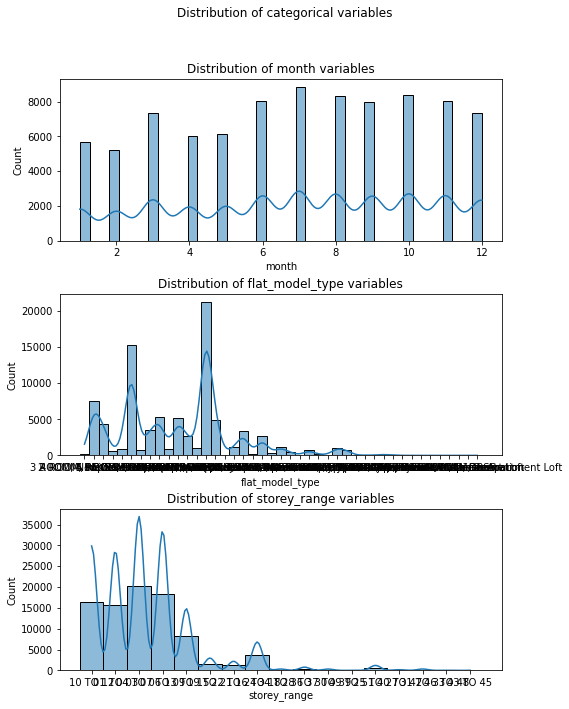

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(categoricalDict.keys(), axes):
    sns.histplot(data=train_dataframe[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of categorical variables')
plt.show()

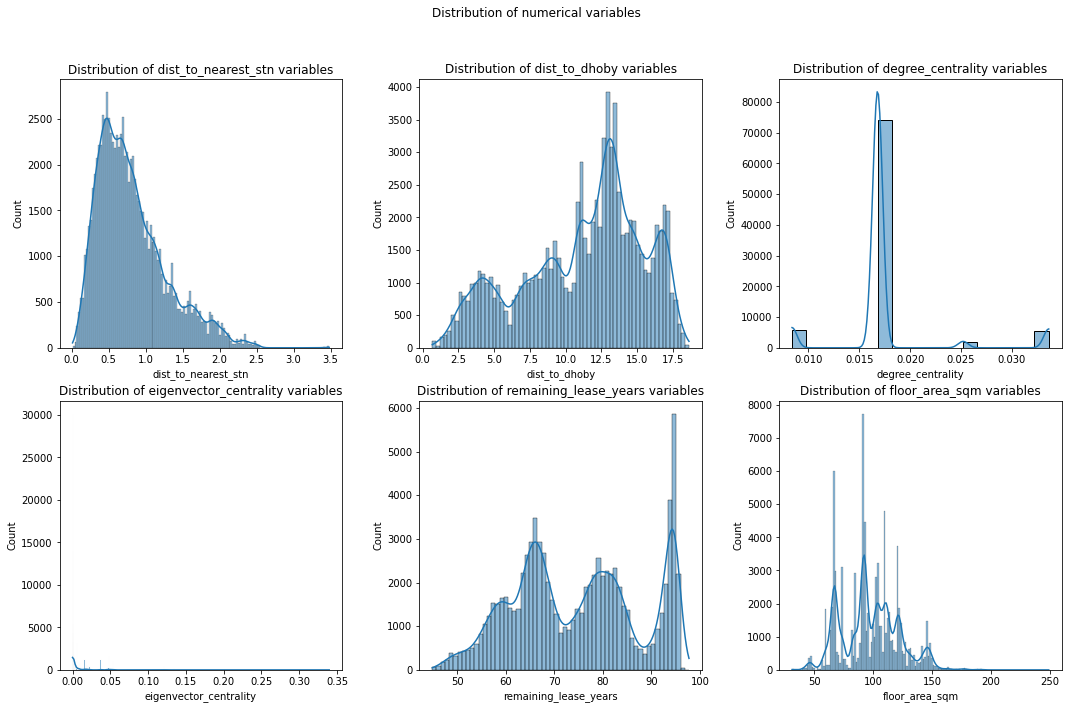

In [ ]:
fig, axes = plt.subplots(len(numericList)//3, 3, figsize=(15, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(numericList, axes):
    sns.histplot(data=train_dataframe[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of numerical variables')
plt.show()

#####**Visualization of data distribution in old_test dataset**

In [ ]:
print("Numbers of categories of each categorical variables: \n")
for cat_var in categoricalDict:
  print("Number of categories for %s is: %d" %(cat_var, len(set(old_test_dataframe[cat_var]))))

Numbers of categories of each categorical variables: 

Number of categories for month is: 8
Number of categories for flat_model_type is: 41
Number of categories for storey_range is: 17


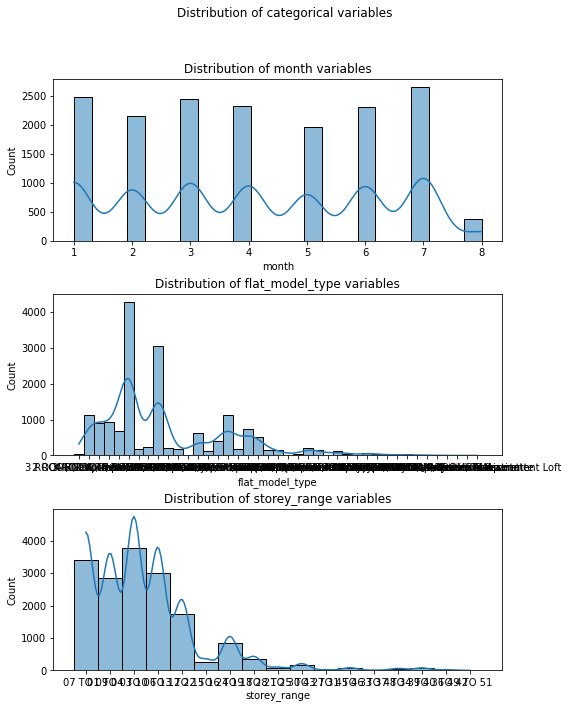

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(categoricalDict.keys(), axes):
    sns.histplot(data=old_test_dataframe[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of categorical variables')
plt.show()

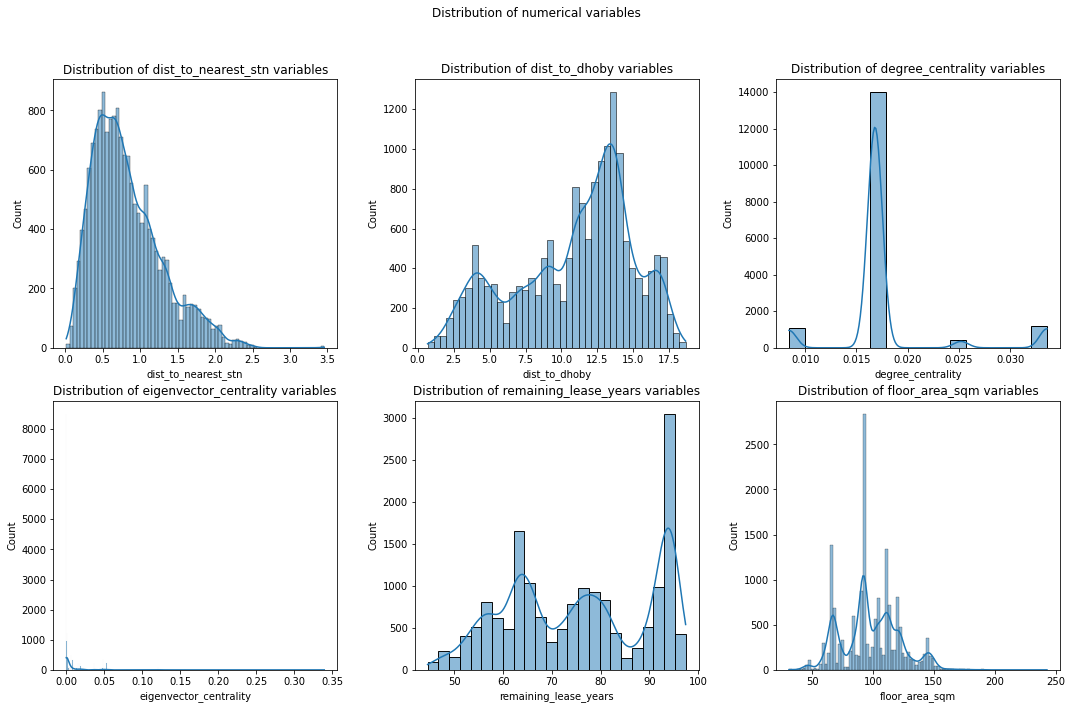

In [ ]:
fig, axes = plt.subplots(len(numericList)//3, 3, figsize=(15, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(numericList, axes):
    sns.histplot(data=old_test_dataframe[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of numerical variables')
plt.show()

From both numerical and categorical variables plots, we can see that the data distributions are similar between training dataset and old_test dataset, except 'month' variable. In old_test dataset, data distribution for month is not even as the training dataset. Other than that, other variables distribution look similar. It can suggest that as the old_test dataset is 2021 year data, which is just 1 year after the latest data in training, the model is capable of inference to this similar data. 

#####**Visualization of data distribution in new_test_2021 dataset**

In [ ]:
print("Numbers of categories of each categorical variables: \n")
for cat_var in categoricalDict:
  print("Number of categories for %s is: %d" %(cat_var, len(set(new_test_dataframe_2021[cat_var]))))

Numbers of categories of each categorical variables: 

Number of categories for month is: 12
Number of categories for flat_model_type is: 42
Number of categories for storey_range is: 17


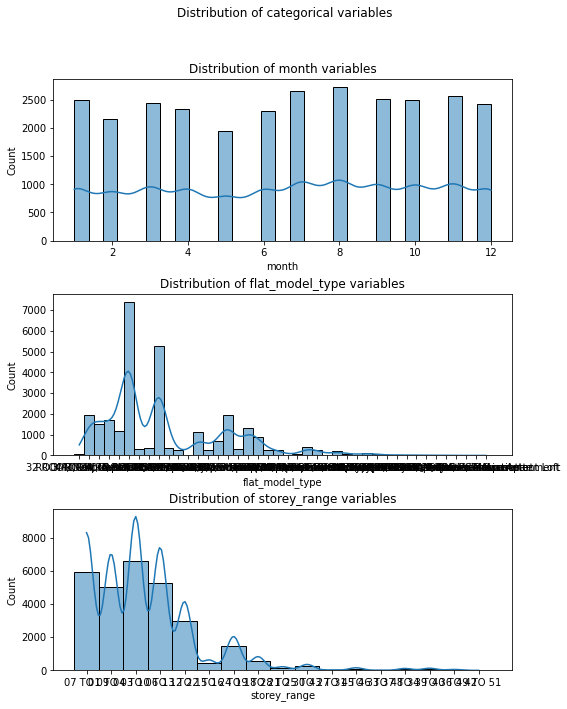

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(categoricalDict.keys(), axes):
    sns.histplot(data=new_test_dataframe_2021[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of categorical variables')
plt.show()

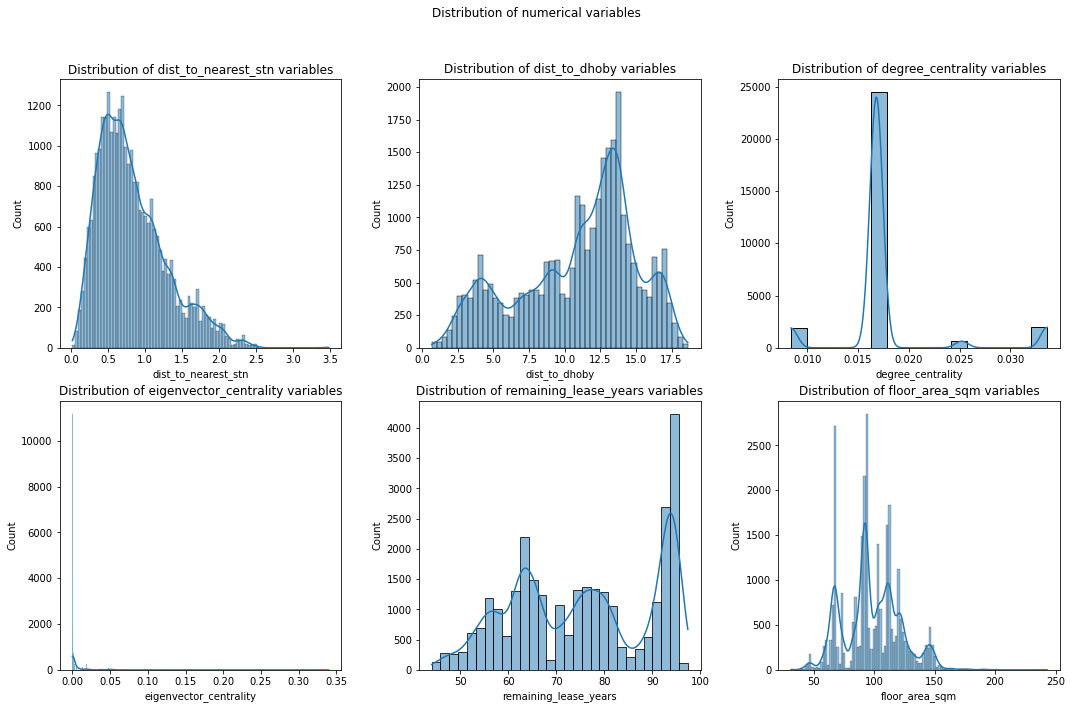

In [ ]:
fig, axes = plt.subplots(len(numericList)//3, 3, figsize=(15, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(numericList, axes):
    sns.histplot(data=new_test_dataframe_2021[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of numerical variables')
plt.show()

For this test dataset, the data distributions of all features also look similar to training dataset. Only degree_centrality, flat_model_type has little different with more counts for values in the left and right.

#####**Visualization of data distribution in new_test_2022 dataset**

In [ ]:
print("Numbers of categories of each categorical variables: \n")
for cat_var in categoricalDict:
  print("Number of categories for %s is: %d" %(cat_var, len(set(new_test_dataframe_2022[cat_var]))))

Numbers of categories of each categorical variables: 

Number of categories for month is: 8
Number of categories for flat_model_type is: 42
Number of categories for storey_range is: 17


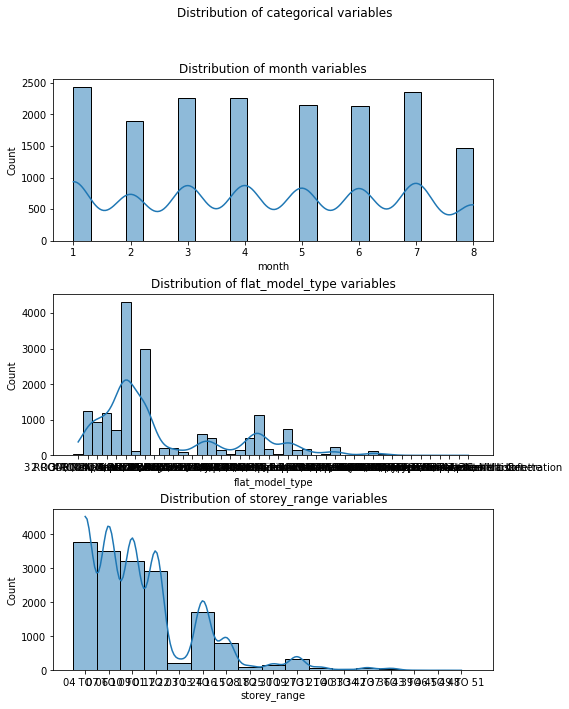

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(categoricalDict.keys(), axes):
    sns.histplot(data=new_test_dataframe_2022[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of categorical variables')
plt.show()

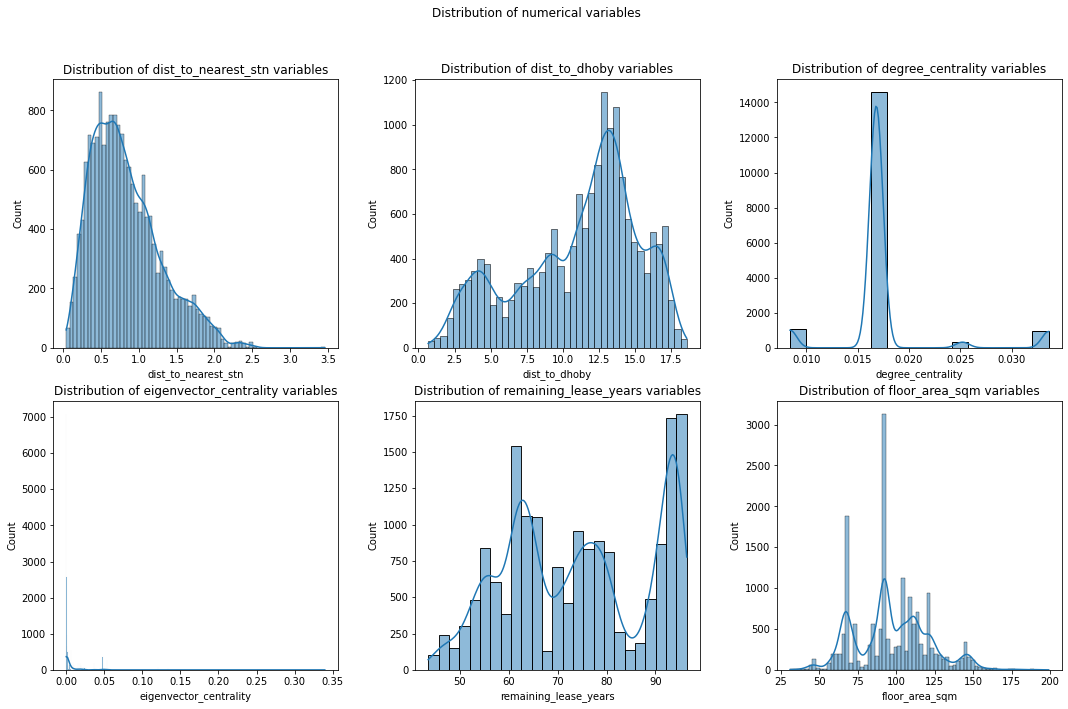

In [ ]:
fig, axes = plt.subplots(len(numericList)//3, 3, figsize=(15, 10))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(numericList, axes):
    sns.histplot(data=new_test_dataframe_2022[col], kde=True, ax=ax)
    ax.set_title("Distribution of %s variables" %col)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Distribution of numerical variables')
plt.show()

This test dataset is 2022 year samples, which is the farthest data to the training data. There are several samples having different data distribution compared to that of training dataset: remaining_lease_years, degree_centrality, storey_range and flat_model_type.

##### **Comments on model degradation**

Overall, the variable(s) showed the largest covariate/label shift could be storey_range,flat_model_type, remaining_lease_years and degree_centrality. Some solutions are :

1. Manual learning: Here, we provide the newly gathered data to our model and re-train and re-deploy it just like the first time we build the model. [2]
2. Weight your data: One recommended weighting schema is to use the inversely proportional age of the data. This way, more attention will be paid to the most recent data (higher weight) and less attention to the oldest of data (smaller weight) in your training set. In this sense, if there is drift, your model will pick it up and correct accordingly. [2]

####**d. The team passed you a script (‘RFE.py’) that recursively removes features from a neural network, so as to find the best feature subset. Run this piece of code with your model from Q2d and report the best feature subset obtained.**

In [ ]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)


import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    categoricalDict = {
      "month": "int64",
      "flat_model_type": "string",
      "storey_range": "string"
    }
    numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
    all_inputs = []
    all_features = []

    for cat, typ in categoricalDict.items():
      encoded_cat = keras.Input(shape=(1,), name=cat, dtype=typ)
      all_inputs.append(encoded_cat)
      if typ == "int64":
        all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, False, hp_best_config['divisor']))
      else:
        all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, True, hp_best_config['divisor']))
    for num in numericList:
      encoded_num = keras.Input(shape=(1,), name=num)
      all_inputs.append(encoded_num)
      all_features.append(encode_numerical_feature(encoded_num, num, train_ds))
  
    selected_features = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features, feature_mask):
        if j == 1:
            selected_features.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_features)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    x = layers.Dense(units=hp_best_config['units'], activation="relu",)(all_features)
    x = layers.Dense(1, activation="linear")(x)
    
    model = keras.Model(all_inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_best_config['learning_rate']),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_ds, epochs=50, validation_data=old_test_ds, verbose=0, batch_size=batch_size, callbacks=[callback])
    val_loss_hx = history.history['val_root_mean_squared_error'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
  
    return val_loss_min



In [ ]:
## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)

vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
---Feature: month ---
this is vocab size  13
this is num of categories  12
this is input dim  13  and output dim  6
---Feature: flat_model_type ---
this is vocab size  44
this is num of categories  44
this is input dim  44  and output dim  22
---Feature: storey_range ---
this is vocab size  18
this is num of categories  17
this is input dim  18  and output dim  8
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 78), dtype=tf.float32, name=None), name='Flattenmonth/Reshape:0', description="created by layer 'Flattenmonth'")
KerasTensor(type_spec=TensorSpec(shape=(None, 968), dtype=tf.float32, name=None), name='Flattenflat_model_type/Reshape:0', description="created by layer 'Flattenflat_model_type'")
KerasTensor(type_spec=TensorSpec(shape=(None, 144), dtype=tf.float32, name=None), name='Flattenstorey_range/Reshape:0', description="created by l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


new min loss: len 9, ix 0
session cleared!

ix 1 i 1
updated temp_vec [1, 0, 1, 1, 1, 1, 1, 1, 1]
---Feature: month ---
this is vocab size  13
this is num of categories  12
this is input dim  13  and output dim  6
---Feature: flat_model_type ---
this is vocab size  44
this is num of categories  44
this is input dim  44  and output dim  22
---Feature: storey_range ---
this is vocab size  18
this is num of categories  17
this is input dim  18  and output dim  8
going through feature_mask [1, 0, 1, 1, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 78), dtype=tf.float32, name=None), name='Flattenmonth/Reshape:0', description="created by layer 'Flattenmonth'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 968), dtype=tf.float32, name=None), name='Flattenflat_model_type/Reshape:0', description="created by layer 'Flattenflat_model_type'")
KerasTensor(type_spec=TensorSpec(shape=(None, 144), dtype=tf.float32, name=None), name='Flattenstorey_range/Reshape:0', description="

The feature map and best_vec are as following:

In [ ]:
feature_map = ["month", "flat_model_type", "storey_range", "dist_to_nearest_stn", "dist_to_dhoby", 
               "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]

In [ ]:
best_vec  = [0, 1, 1, 1, 1, 1, 1, 1, 0]

The best subset of feature is ["flat_model_type", "storey_range", "dist_to_nearest_stn", "dist_to_dhoby", 
               "degree_centrality", "eigenvector_centrality", "remaining_lease_years"]

####**e) RFE on the ‘old test set’ eliminated features degree_centrality and month. It also showed that dist_to_dhoby and dist_to_nearest_stn are crucial (removing them leads to higher test loss). Compare these features to those in Q3d and discuss whether concept drift has occurred.**

From the log, we can see our model achieve best result when remove feature "month" and "floor_area_sqm". 

In some circumstances it may be possible to remove the drifting feature and hope that retraining uses alternate features to achieve similar predictive power [3]. Here, when we remove the 2 mentioned features, the test error is reduced, hence, such features' distributions probably change in test dataset comapred to these of training dataset and degrade our model's performance. The concept drift likely happens.

# **Conclusion**

Possible discussion pointers for conclusion:
- **In Q1, we compared a linear regression model to an equivalent neural network
architecture and also saw how adding a hidden layer changes model performance. In
Q2, we saw how adding an Embedding layer introduces more learnable parameters to
the neural network. What other benefits do neural networks have over other machine
learning approaches? In cases where neural networks perform better, is it possible to
modify ‘traditional’ machine learning algorithms to close up the gap?**
 In traditional Machine learning techniques, most of the applied features need to be identified by an domain expert in order to reduce the complexity of the data and make patterns more visible to learning algorithms to work. On the other hand, Deep Learning algorithms try to learn high-level features from data in an incremental manner. This eliminates the need of domain expertise and hard core feature extraction. [4]

- **In Q2, we tried out another approach of model tuning. KerasTuner offers many other
algorithms – how do Bayesian optimisation or HyperBand work? Are they necessarily
better than random search? Also, is random search better than grid search?** **Grid Search** is defining a set of parameter values, train model for all possible parameter combinations and select the best one [5]. **Random Search**, on the other hand, will just use randomly selected subset of the parameters. Random Search can drastically reduce the training time compared to Grid Search. However, it may not find the most optimal combination as it is random-based method [5]. Another algorithms is **Bayesian optimization**. It is a derivative-free optimization method. They keep track of past evaluation results which they use to form a probabilistic model mapping hyperparameters to a probability of a score on a designed objective function. At a high-level, Bayesian optimization methods are efficient because they choose the next hyperparameters in an informed manner. The basic idea is: spend a little more time selecting the next hyperparameters in order to make fewer calls to the objective function [6].

- **In Q3, we witnessed what happened to machine learning models if they are not
updated with the latest datasets and looked at whether covariate shift, label shift or
concept drift has occurred. Which of these have led to model degradation? Was the
change in LTV ratio the cause of it (if so, how did it affect the model performance)?**
As explained in previous parts, for time dependent dataset like ours, concept drift is the most frequently seen factor causing degradation. Here, HDB loan-to-value was lowerred which also be a change in context that affect our test data.

# **References**

[1] https://huyenchip.com/2022/02/07/data-distribution-shifts-and-monitoring.html#concept-drift

[2] https://paulvanderlaken.com/2020/03/24/ml-model-performance-degradation-production-concept-drift/

[3] https://towardsdatascience.com/drift-in-machine-learning-e49df46803a

[4] https://towardsdatascience.com/why-deep-learning-is-needed-over-traditional-machine-learning-1b6a99177063

[5] http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html

[6] https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f